# Validation

## Generate data

Below, we simulate data `D`.

* $X_1 \sim \mathcal{N}(0, 1)$
* $X_2 \sim \mathcal{N}(0, 1)$
* $X_3$ is 
  * `red` when $X_1 < 0$ and $X_2 < 0$
  * `green` when $X_1 > 0$ and $X_2 > 0$
  * `blue` otherwise
* $Y_0 = 1 + 2X_1 + 3X_2 + \sigma$
* $Y_1 = \frac{1}{1 + \exp(-Y_0)}$
* $y \sim \mathcal{Binom}(Y_1)$

In [1]:
suppressMessages({
    library('dplyr')
    library('purrr')
})

set.seed(37)

getColor <- function(a, b) {
    if (a < 0 && b < 0) {
        return('red')
    } else if (a > 0 && b > 0) {
        return('green')
    } else {
        return('blue')
    }
}

getData <- function(N=1000) {
    x1 <- rnorm(N, mean=0, sd=1)
    x2 <- rnorm(N, mean=0, sd=1)
    x3 <- map2(x1, x2, getColor) %>% flatten_chr()
    y <- 1 + 2.0 * x1 + 3.0 * x2 + rnorm(N, mean=0, sd=1)
    y <- 1.0 / (1.0 + exp(-y))
    y <- rbinom(n=N, size=1, prob=y)

    df <- data.frame(x1=x1, x2=x2, x3=x3, y=y)
    df <- df %>%
            mutate(y=ifelse(y == 0, 'neg', 'pos')) %>%
            mutate_at('y', as.factor)
    
    return(df)
}

D <- getData()

In [2]:
print(sapply(D, is.factor))

   x1    x2    x3     y 
FALSE FALSE  TRUE  TRUE 


In [3]:
print(head(D))

          x1         x2    x3   y
1  0.1247540  0.4817417 green pos
2  0.3820746  0.8176848 green pos
3  0.5792428 -0.3254274  blue pos
4 -0.2937481 -0.2674061   red pos
5 -0.8283492  1.7163252  blue pos
6 -0.3327136  1.2376945  blue pos


In [4]:
print(summary(D))

       x1                x2               x3        y      
 Min.   :-2.8613   Min.   :-3.28763   blue :502   neg:394  
 1st Qu.:-0.6961   1st Qu.:-0.59550   green:257   pos:606  
 Median :-0.0339   Median : 0.06348   red  :241            
 Mean   :-0.0184   Mean   : 0.03492                        
 3rd Qu.: 0.6836   3rd Qu.: 0.69935                        
 Max.   : 3.8147   Max.   : 3.17901                        


In [5]:
print(dim(D))

[1] 1000    4


## Generate missing data

Here, we make 10% of the data missing in `D` and store the results in `D.M`.

In [6]:
suppressMessages({
    library('missForest')
})

D.M <- prodNA(D[c('x1', 'x2', 'x3')], noNA=0.1)
D.M$y <- D$y

In [7]:
print(summary(D.M))

       x1                 x2               x3        y      
 Min.   :-2.86131   Min.   :-3.28763   blue :457   neg:394  
 1st Qu.:-0.70096   1st Qu.:-0.61616   green:225   pos:606  
 Median :-0.02752   Median : 0.06288   red  :213            
 Mean   :-0.03416   Mean   : 0.03213   NA's :105            
 3rd Qu.: 0.65422   3rd Qu.: 0.69815                        
 Max.   : 3.81473   Max.   : 3.17901                        
 NA's   :102        NA's   :93                              


In [8]:
print(dim(D))

[1] 1000    4


## Split data

Now we split `D.M` into 80% training `D.T` and 20% testing `D.V`.

In [10]:
suppressMessages({
    library('caret')
})

trIndices <- createDataPartition(D$y, times=1, p=0.8, list=FALSE)

D.T <- D.M[trIndices, ]
D.V <- D.M[-trIndices, ]

In [18]:
print(head(D.T))

          x1         x2    x3   y
1  0.1247540  0.4817417 green pos
2  0.3820746  0.8176848 green pos
3  0.5792428 -0.3254274  blue pos
5         NA  1.7163252  blue pos
7 -0.1921595 -1.1223299   red neg
8  1.3629827  1.5202646  <NA> pos


In [19]:
print(head(D.V))

           x1         x2    x3   y
4  -0.2937481 -0.2674061   red pos
6  -0.3327136  1.2376945  blue pos
26 -0.4590474  1.5723978  blue pos
29 -2.1039691  1.0775911  blue pos
33  0.6553955         NA  blue neg
36  0.1297151  0.2434078 green pos


In [11]:
print(dim(D.T))

[1] 801   4


In [12]:
print(dim(D.V))

[1] 199   4


## Profile data

### Statistical profiles

Now, let's quickly look at the data profiles.

#### Training profile

In [20]:
library('skimr')

skimmed <- skim(D.T[,1:2])
s <- skimmed[, c(2:6, 12)]
print(s)

# A tibble: 2 x 6
  skim_variable n_missing complete_rate numeric.mean numeric.sd numeric.hist
  <chr>             <int>         <dbl>        <dbl>      <dbl> <chr>       
1 x1                   87         0.891      -0.0156      0.994 ▁▅▇▃▁       
2 x2                   73         0.909       0.0337      1.04  ▁▃▇▅▁       


In [23]:
skimmed <- skim(D.T[,3:4])
s <- skimmed[, c(2:7)]
print(s)

# A tibble: 2 x 6
  skim_variable n_missing complete_rate factor.ordered factor.n_unique
  <chr>             <int>         <dbl> <lgl>                    <int>
1 x3                   81         0.899 FALSE                        3
2 y                     0         1     FALSE                        2
# … with 1 more variable: factor.top_counts <chr>


#### Validation profile

In [24]:
skimmed <- skim(D.V[,1:2])
s <- skimmed[, c(2:6, 12)]
print(s)

# A tibble: 2 x 6
  skim_variable n_missing complete_rate numeric.mean numeric.sd numeric.hist
  <chr>             <int>         <dbl>        <dbl>      <dbl> <chr>       
1 x1                   15         0.925      -0.106       1.05  ▂▇▇▂▁       
2 x2                   20         0.899       0.0257      0.977 ▁▂▇▅▁       


In [25]:
skimmed <- skim(D.V[,3:4])
s <- skimmed[, c(2:7)]
print(s)

# A tibble: 2 x 6
  skim_variable n_missing complete_rate factor.ordered factor.n_unique
  <chr>             <int>         <dbl> <lgl>                    <int>
1 x3                   24         0.879 FALSE                        3
2 y                     0         1     FALSE                        2
# … with 1 more variable: factor.top_counts <chr>


### Missingness profiles

Below, we visually inspect the data missingness.


 Variables sorted by number of missings: 
 Variable Count
       x3 0.105
       x1 0.102
       x2 0.093
        y 0.000


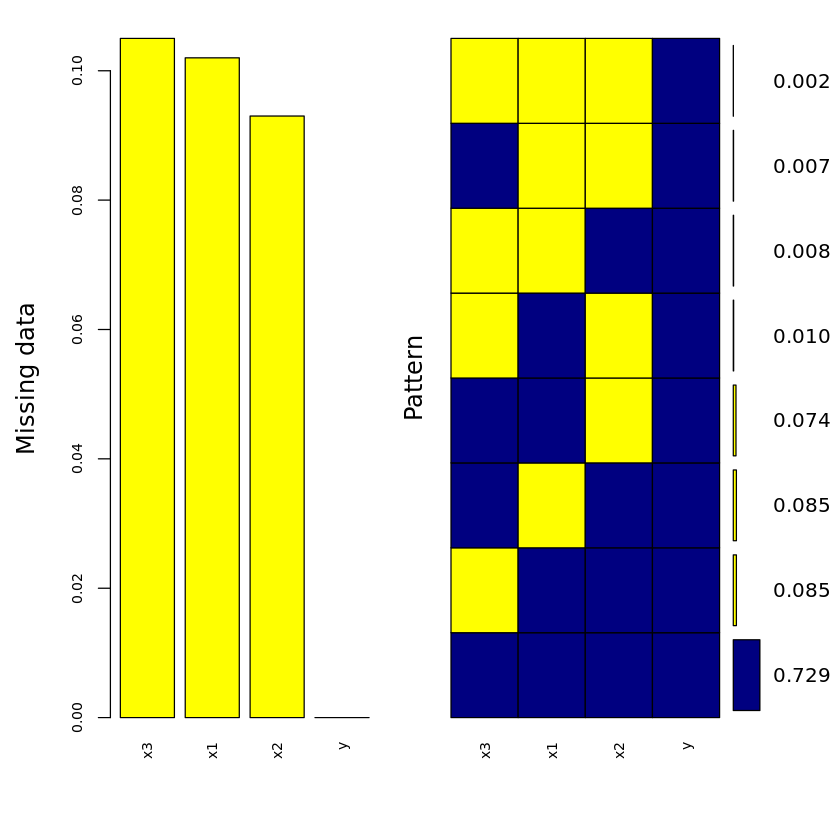

In [30]:
suppressMessages({
    library('VIM')
})

p <- aggr(
    D.M,
    col=c('navyblue','yellow'),
    numbers=TRUE,
    sortVars=TRUE,
    labels=names(D.M),
    cex.axis=.7,
    gap=3,
    ylab=c('Missing data', 'Pattern')
)

Warning message in plot.aggr(res, ...):
“not enough horizontal space to display frequencies”


 Variables sorted by number of missings: 
 Variable      Count
       x1 0.10861423
       x3 0.10112360
       x2 0.09113608
        y 0.00000000


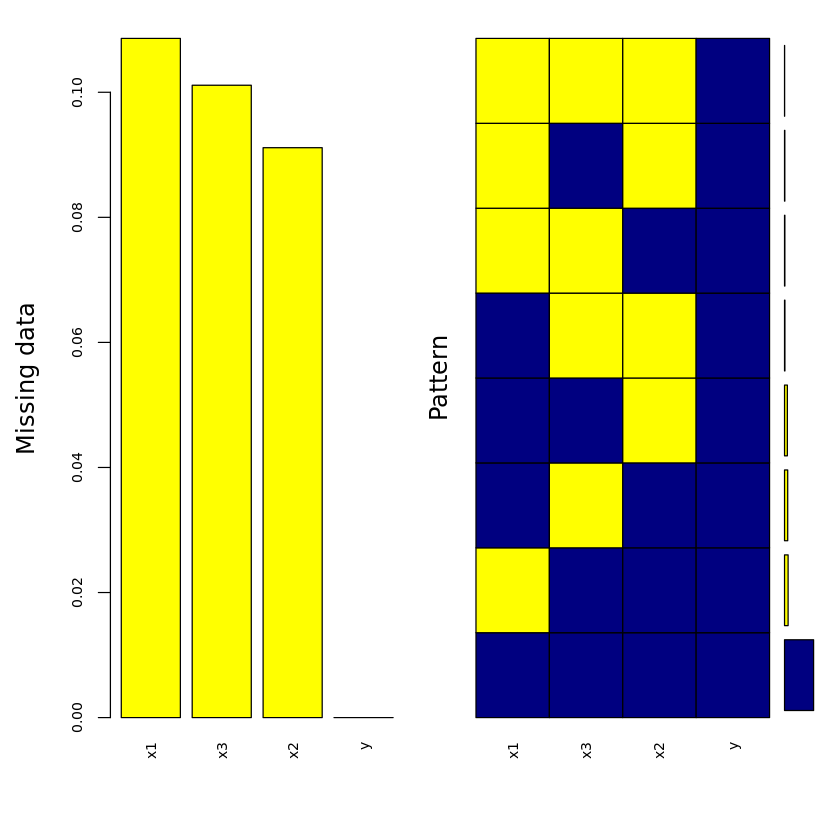

In [31]:
p <- aggr(
    D.T,
    col=c('navyblue','yellow'),
    numbers=TRUE,
    sortVars=TRUE,
    labels=names(D.T),
    cex.axis=.7,
    gap=3,
    ylab=c('Missing data', 'Pattern')
)


 Variables sorted by number of missings: 
 Variable      Count
       x3 0.12060302
       x2 0.10050251
       x1 0.07537688
        y 0.00000000


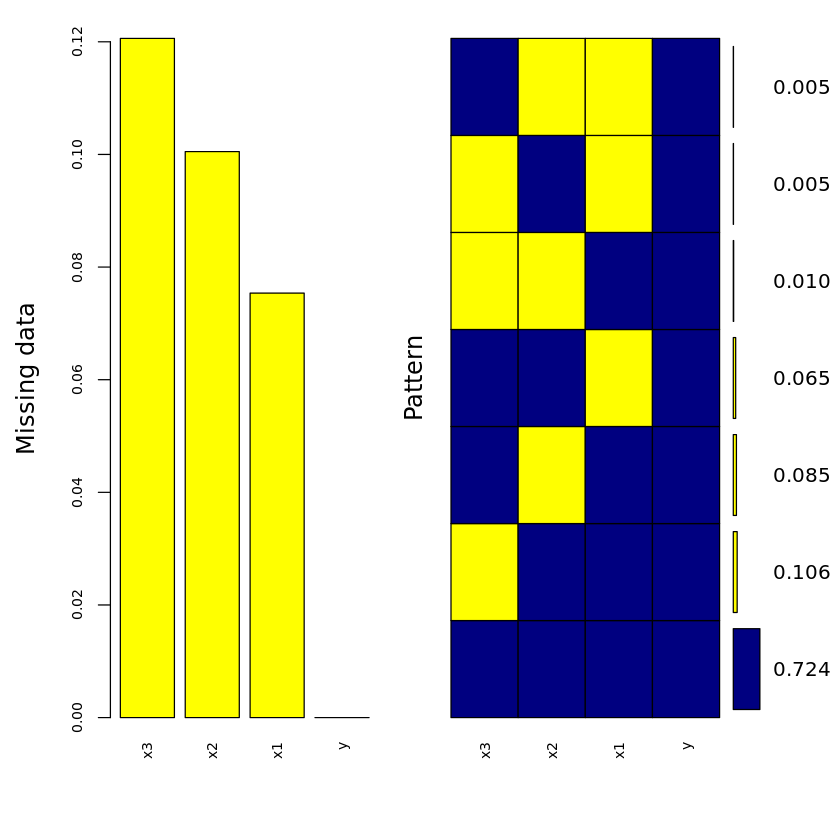

In [32]:
p <- aggr(
    D.V,
    col=c('navyblue','yellow'),
    numbers=TRUE,
    sortVars=TRUE,
    labels=names(D.V),
    cex.axis=.7,
    gap=3,
    ylab=c('Missing data', 'Pattern')
)

## One-hot encoding

We perform one-hot encoding on the categorical variables and store the result in `D.O`.

In [52]:
ohe <- dummyVars(~ ., data=D.T[,-4], sep='_')
D.O <- data.frame(predict(ohe, newdata=D[,-4]))
D.O$y <- D$y

In [53]:
print(head(D.O))

          x1         x2 x3_blue x3_green x3_red   y
1  0.1247540  0.4817417       0        1      0 pos
2  0.3820746  0.8176848       0        1      0 pos
3  0.5792428 -0.3254274       1        0      0 pos
4 -0.2937481 -0.2674061       0        0      1 pos
5 -0.8283492  1.7163252       1        0      0 pos
6 -0.3327136  1.2376945       1        0      0 pos


In [54]:
print(summary(D.O))

       x1                x2              x3_blue         x3_green    
 Min.   :-2.8613   Min.   :-3.28763   Min.   :0.000   Min.   :0.000  
 1st Qu.:-0.6961   1st Qu.:-0.59550   1st Qu.:0.000   1st Qu.:0.000  
 Median :-0.0339   Median : 0.06348   Median :1.000   Median :0.000  
 Mean   :-0.0184   Mean   : 0.03492   Mean   :0.502   Mean   :0.257  
 3rd Qu.: 0.6836   3rd Qu.: 0.69935   3rd Qu.:1.000   3rd Qu.:1.000  
 Max.   : 3.8147   Max.   : 3.17901   Max.   :1.000   Max.   :1.000  
     x3_red        y      
 Min.   :0.000   neg:394  
 1st Qu.:0.000   pos:606  
 Median :0.000            
 Mean   :0.241            
 3rd Qu.:0.000            
 Max.   :1.000            


## Imputation

We will preprocess the training data using `k-nearest neighbor` imputation.

In [36]:
library('RANN')

imp <- preProcess(D.O, method='knnImpute')
D.I <- predict(imp, newdata=D.O)

print(anyNA(D.I))

[1] FALSE


In [37]:
print(head(D.I))

          x1         x2    x3_blue   x3_green    x3_red   y
1  0.1408176  0.4391669 -1.0035059  1.6994586 -0.563210 pos
2  0.3939391  0.7693556 -1.0035059  1.6994586 -0.563210 pos
3  0.5878898 -0.3541760  0.9955098 -0.5878343 -0.563210 pos
4 -0.2708553 -0.2971486 -1.0035059 -0.5878343  1.773761 pos
5 -0.7967326  1.6526029  0.9955098 -0.5878343 -0.563210 pos
6 -0.3091849  1.1821708  0.9955098 -0.5878343 -0.563210 pos


In [38]:
print(summary(D.I))

       x1                 x2              x3_blue           x3_green      
 Min.   :-2.79652   Min.   :-3.26564   Min.   :-1.0035   Min.   :-0.5878  
 1st Qu.:-0.66661   1st Qu.:-0.61962   1st Qu.:-1.0035   1st Qu.:-0.5878  
 Median :-0.01525   Median : 0.02807   Median : 0.9955   Median :-0.5878  
 Mean   : 0.00000   Mean   : 0.00000   Mean   : 0.0000   Mean   : 0.0000  
 3rd Qu.: 0.69053   3rd Qu.: 0.65305   3rd Qu.: 0.9955   3rd Qu.: 1.6995  
 Max.   : 3.77058   Max.   : 3.09023   Max.   : 0.9955   Max.   : 1.6995  
     x3_red          y      
 Min.   :-0.5632   neg:394  
 1st Qu.:-0.5632   pos:606  
 Median :-0.5632            
 Mean   : 0.0000            
 3rd Qu.:-0.5632            
 Max.   : 1.7738            


## Rescale

In [39]:
ran <- preProcess(D.I, method='range')
D.R <- predict(ran, newdata=D.I)

In [40]:
print(head(D.R))

         x1        x2 x3_blue x3_green x3_red   y
1 0.4472809 0.5828955       0        1      0 pos
2 0.4858248 0.6348457       0        1      0 pos
3 0.5153584 0.4580750       1        0      0 pos
4 0.3845938 0.4670474       0        0      1 pos
5 0.3045163 0.7738113       1        0      0 pos
6 0.3787572 0.6997959       1        0      0 pos


In [41]:
print(summary(D.R))

       x1               x2            x3_blue         x3_green    
 Min.   :0.0000   Min.   :0.0000   Min.   :0.000   Min.   :0.000  
 1st Qu.:0.3243   1st Qu.:0.4163   1st Qu.:0.000   1st Qu.:0.000  
 Median :0.4235   Median :0.5182   Median :1.000   Median :0.000  
 Mean   :0.4258   Mean   :0.5138   Mean   :0.502   Mean   :0.257  
 3rd Qu.:0.5310   3rd Qu.:0.6165   3rd Qu.:1.000   3rd Qu.:1.000  
 Max.   :1.0000   Max.   :1.0000   Max.   :1.000   Max.   :1.000  
     x3_red        y      
 Min.   :0.000   neg:394  
 1st Qu.:0.000   pos:606  
 Median :0.000            
 Mean   :0.241            
 3rd Qu.:0.000            
 Max.   :1.000            


In [42]:
print(dim(D.R))

[1] 1000    6


## Feature importance

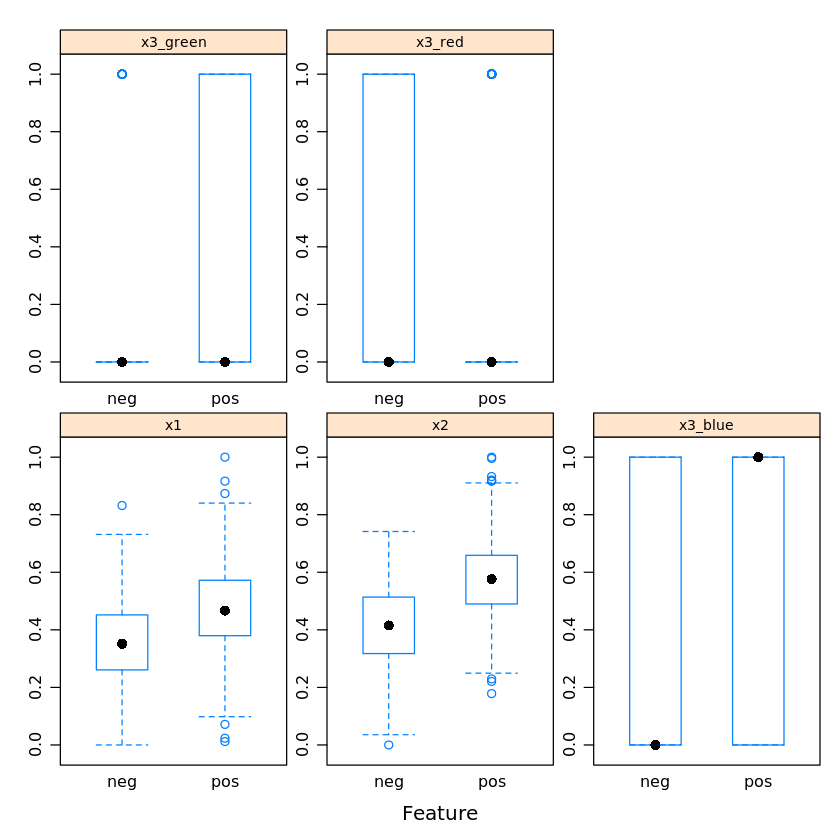

In [43]:
featurePlot(x=D.R[,1:5], 
            y=D.R$y, 
            plot='box',
            strip=strip.custom(par.strip.text=list(cex=.7)),
            scales = list(x = list(relation='free'), 
                          y = list(relation='free')))

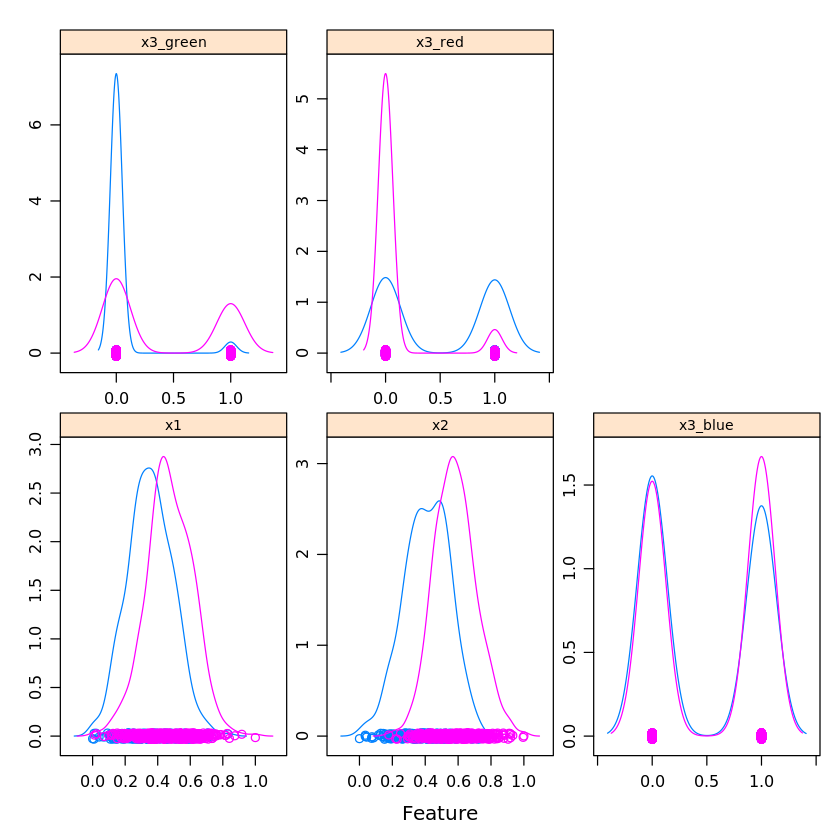

In [44]:
featurePlot(x=D.R[,1:5], 
            y=D.R$y, 
            plot='density',
            strip=strip.custom(par.strip.text=list(cex=.7)),
            scales = list(x = list(relation='free'), 
                          y = list(relation='free')))

## Feature selection

In [45]:
ctrl <- rfeControl(
    functions=rfFuncs,
    method='repeatedcv',
    repeats=5,
    verbose=FALSE
)

profile <- rfe(y ~ ., data=D.R, sizes=c(2, 3), rfeControl=ctrl)

In [46]:
profile


Recursive feature selection

Outer resampling method: Cross-Validated (10 fold, repeated 5 times) 

Resampling performance over subset size:

 Variables Accuracy  Kappa AccuracySD KappaSD Selected
         2   0.8028 0.5861    0.03459 0.07315         
         3   0.8102 0.5908    0.03654 0.08220         
         5   0.8214 0.6186    0.03640 0.08056        *

The top 5 variables (out of 5):
   x2, x1, x3_red, x3_green, x3_blue


## Training

### Random forest

In [47]:
modelLookup('rf')

model,parameter,label,forReg,forClass,probModel
<chr>,<fct>,<fct>,<lgl>,<lgl>,<lgl>
rf,mtry,#Randomly Selected Predictors,TRUE,TRUE,TRUE


In [48]:
M <- train(y ~ ., data=D.R, method='rf')

In [49]:
M

Random Forest 

1000 samples
   5 predictor
   2 classes: 'neg', 'pos' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1000, 1000, 1000, 1000, 1000, 1000, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
  2     0.8192793  0.6111993
  3     0.8136866  0.6049471
  5     0.7961271  0.5705189

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 2.

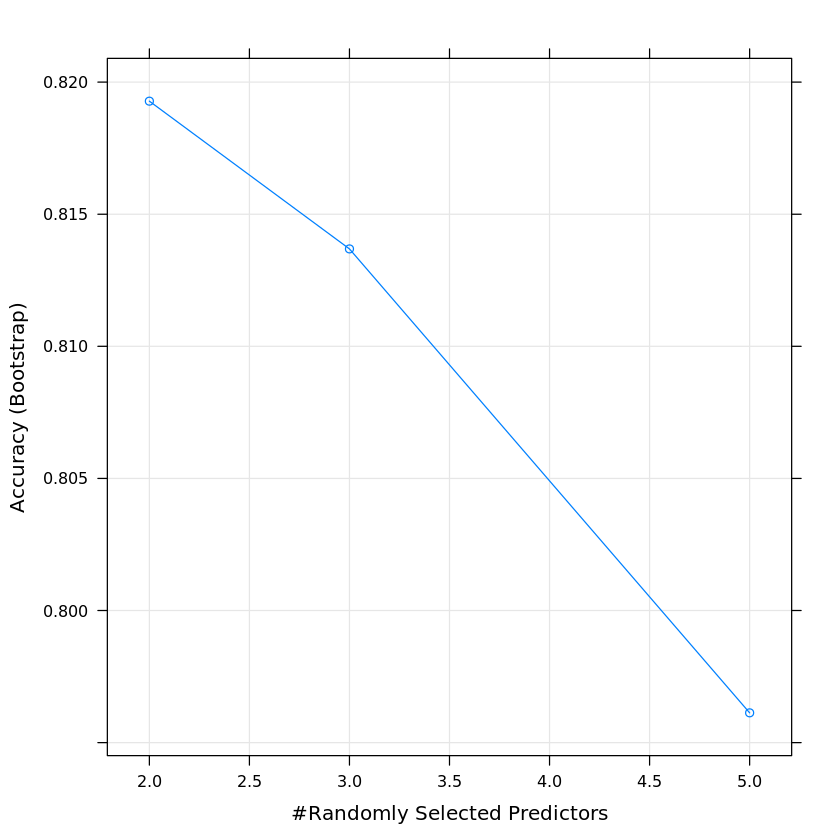

In [50]:
plot(M)

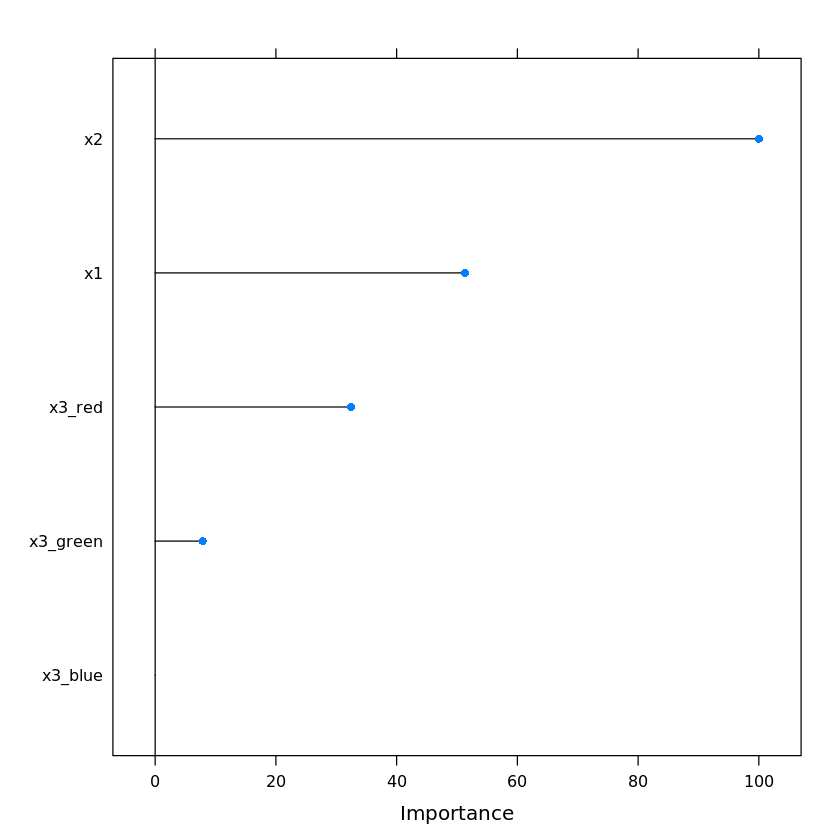

In [51]:
vi <- varImp(M)
plot(vi)

## Predicting on validation data

### Transform validation data

In [55]:
O <- predict(ohe, newdata=D.V)

In [56]:
I <- predict(imp, newdata=O)

In [57]:
R <- predict(ran, newdata=I)

In [58]:
print(head(R))

          x1        x2 x3_blue x3_green x3_red
4  0.3845938 0.4670474       0        0      1
6  0.3787572 0.6997959       1        0      0
26 0.3598337 0.7515544       1        0      0
29 0.1134421 0.6750376       1        0      0
33 0.5267653 0.4183815       1        0      0
36 0.4480240 0.5460396       0        1      0


In [59]:
print(dim(R))

[1] 199   5


### Confusion matrix

In [60]:
P <- predict(M, R)

In [66]:
cm <- confusionMatrix(reference=D.V$y, data=P, positive='pos')

In [67]:
cm

Confusion Matrix and Statistics

          Reference
Prediction neg pos
       neg  62  16
       pos  16 105
                                          
               Accuracy : 0.8392          
                 95% CI : (0.7806, 0.8873)
    No Information Rate : 0.608           
    P-Value [Acc > NIR] : 1.118e-12       
                                          
                  Kappa : 0.6626          
                                          
 Mcnemar's Test P-Value : 1               
                                          
            Sensitivity : 0.8678          
            Specificity : 0.7949          
         Pos Pred Value : 0.8678          
         Neg Pred Value : 0.7949          
             Prevalence : 0.6080          
         Detection Rate : 0.5276          
   Detection Prevalence : 0.6080          
      Balanced Accuracy : 0.8313          
                                          
       'Positive' Class : pos             
                              

### ROC

In [73]:
P <- predict(M, R, type='prob')[,2]

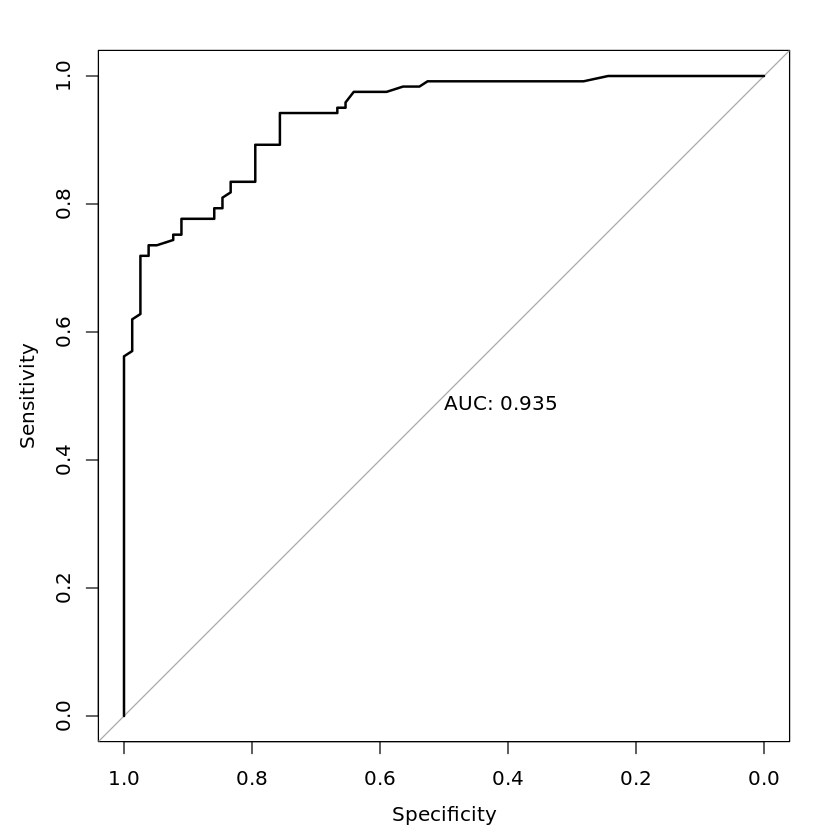

In [76]:
suppressMessages({
    library('pROC')
})

r <- roc(D.V$y, P, levels=c('neg', 'pos'), direction='<')
plot(r, print.auc=TRUE)